# <center>Logistic Regression</center>  逻辑回归

![logistic-regression](./pics/logistic-regression.png)

### Goal of lecture 11

* How logistic regression works. Classification problem. 分类问题
* Why mchine learning needs a balanced dataset 平衡数据集
* How to deal with categorical features. Index and Encode  如何处理分类特征。 索引和编码
* What is vectorization and why  向量化
* Implement machine learning project in Apache Spark  在Apache Spark中实施机器学习项目
* How to evaluate the performance of your classification model (classifier)  分类模型


## Logistic Regression  是一个分类算法

* Don't be confused!! Logistic Regression is NOT a regression algorithm, but a **Classification** algorith. 
* Logistic回归不是回归算法，而是分类算法。
* Why have 'regression' in the name then
* Binary classification. E.g., pass the exam or not, is this email spam or not.
* Output is 0 or 1. 1 when greater than a threshold, otherwise 0.
* Can be expaned to multi-class classification.也可以扩展为 多类分类

### Idealy to have an equation like this

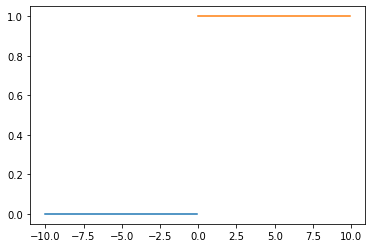

In [5]:
import numpy as np
import matplotlib.pyplot as plt

z0 = np.arange(-10, 0, 0.1)
z1 = np.arange(0, 10, 0.1)
y0 = 0 + 0*z0
y1 = 1 + 0*z1

plt.plot(z0, y0, '-')
plt.plot(z1, y1, '-')
plt.show()

### Realistically use below equation for approximation

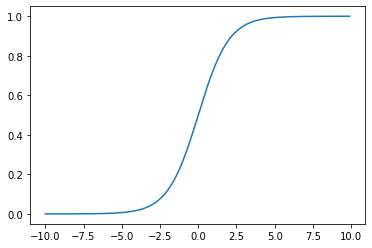

In [6]:
#实际上用下面的方程进行近似  阶跃函数
z = np.arange(-10, 10, 0.1)

y = 1 / (1 + np.exp(-z))
plt.plot(z, y, '-')
plt.show()

### What is Z? Linear Regression!!

$ y = f(z) = \frac {1} {1 + e^{-z}} $

$ z = g(x) = \beta_0x_0 + \beta_1x_1 + \dots + \beta_px_p =\sum_{j=0}^p x_j\beta_j $  线性回归的公式

$ y = \frac {1} {1 + e^{-\sum_{j=0}^p x_j\beta_j}} = \frac {1} {1 + e^{-\beta^TX}} $

$ 1 - y = \frac {e^{-\sum_{j=0}^p x_j\beta_j}} {1 + e^{-\sum_{j=0}^p x_j\beta_j}} = \frac {e^{-\beta^TX}} {1 + e^{-\beta^TX}} $

$ \frac {y} {1-y} = e^{\beta^TX} $

$ \ln \frac {y} {1 - y} = \beta^TX $

In [7]:
#阶跃函数 

# 逻辑回归的本质 是 用线性方程拟合几率的对数  上面最重要的是 z 在起作用， z 就是线性方程
#考上大学
y = 0.99
1-y = 0.01
y/1-y = 99
ln 99 = 8

y/1-y 发生的几率
#考不上大学
y = 0.01
1-y = 0.99
y/1-y = 1/99
ln 1/99 = -8

SyntaxError: invalid syntax (<ipython-input-7-123c9097cb96>, line 8)

| | |
| - | - |
| $ y $ | probability of positive case |
| $ 1-y $ | probability of negative case |
| $ \frac {y} {1-y} $ | odds(几率) |
| $ \ln \frac {y} {1-y} $ | log odds, logit |

### Logistic Regression tries to use linear regression to approximate log odds (logit). 
Logistic回归尝试使用线性回归来近似  对数几率（logit）

<hr/>

## Sample Project

### Business Goal

Use Logistic Regression to predict if a bank customer would make a deposit

### Data Source

* [Kaggle Bank Marketing](https://www.kaggle.com/rouseguy/bankbalanced/data)
* [UCI (University of California, Irvine)](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing)

### Data

In [23]:
! ls -al ./data/bank/

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [24]:
# 对数据的读取，清洗，处理 占到一个项目百分之80的时间

from pyspark.sql import SparkSession
# SparkSession 与spark 进行连接创建一个实例
spark = SparkSession.builder.appName('logistic-regression').getOrCreate()
#读入数据
df = spark.read.csv('./data/bank/bank.csv', header=True, inferSchema=True)

df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



* Schema shows all the column names and their data type. 
* Last column 'deposit' is dependent variable, or target. This is what we want to predict.
* All other columns are features or predictors.

#### Input variables  数据解释

* default: has credit in default? (categorical: 'no','yes','unknown')

* housing: has housing loan? (categorical: 'no','yes','unknown')

* loan: has personal loan? (categorical: 'no','yes','unknown')

* contact: contact communication type (categorical: 'cellular','telephone')

* month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

* day: last contact day of the week

* duration: last contact duration, in seconds (numeric). 

* campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

* pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

* previous: number of contacts performed before this campaign and for this client (numeric)

* poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

#### Output variable (desired target)

* deposit: has the client subscribed a term deposit? (binary: 'yes','no')

In [25]:
# peek the data

df.show(5, False)  # false 不要截断

+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|job       |marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|59 |admin.    |married|secondary|no     |2343   |yes    |no  |unknown|5  |may  |1042    |1       |-1   |0       |unknown |yes    |
|56 |admin.    |married|secondary|no     |45     |no     |no  |unknown|5  |may  |1467    |1       |-1   |0       |unknown |yes    |
|41 |technician|married|secondary|no     |1270   |yes    |no  |unknown|5  |may  |1389    |1       |-1   |0       |unknown |yes    |
|55 |services  |married|secondary|no     |2476   |yes    |no  |unknown|5  |may  |579     |1       |-1   |0       |unknown |yes    |
|54 |admin.    |married|tertiary |no     |184    |no     |no  |unknown|5  |m

In [26]:
import pandas as pd
# more readable if we do a transpose 当数据比较长可以对表格进行转置
pd.DataFrame(df.take(5), columns=df.columns).transpose()  # transpose() 转置

# more than one way to do the same thing
# df.limit(5).toPandas().transpose()

,0,1,2,3,4
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no
contact,unknown,unknown,unknown,unknown,unknown
day,5,5,5,5,5


In [27]:
# check if data is balanced. why?  根据deposit进行分类
df.groupby('deposit').count().toPandas() # toPandas() 显示出来

,deposit,count
0,no,5873
1,yes,5289


In [28]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']  # 选择所有int 型的数据
# same as above, convert to Pandas dataframe, transpose and show. 
# This time we do it in a different way, just to make it more readable
# 做 describe()还是这个包，直接调用做

df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,11162,41.231947679627304,11.913369192215518,18,95
balance,11162,1528.5385235620856,3225.413325946149,-6847,81204
day,11162,15.658036194230425,8.420739541006462,1,31
duration,11162,371.99381831213043,347.12838571630687,2,3881
campaign,11162,2.508421429851281,2.7220771816614824,1,63
pdays,11162,51.33040673714388,108.75828197197717,-1,854
previous,11162,0.8325568894463358,2.292007218670508,0,58


In [29]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [30]:
# contact, day, month are irrelevant for analysis and prediction
# 选择真正有用的，把没用的去掉
df = df.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')
cols = df.columns
cols

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'deposit']

In [31]:
df.printSchema()  # 列变少了

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



### Encode Categorical Features  分类编码功能

#### 1. Why need to encode 编码

#### 2. How to do it

* step1 - Index
* step2 - Encode

In [32]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []

In [33]:
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    #stage 一个数组
    stages += [stringIndexer, encoder]

In [34]:
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]

### [What is Vectorization and Why](https://www.quantifisolutions.com/vectorization-part-2-why-and-what)

In [35]:
# for numeric columsn, we just use them directly
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols

# VectorAssembler, vectorize those input columns specified by assemblerInputs
# put the output into a new column called features
#做成一个向量
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [36]:
stages

[StringIndexer_11f973649459,
 OneHotEncoderEstimator_2209008077b9,
 StringIndexer_5cbd6edfdf7d,
 OneHotEncoderEstimator_ab1d594b545c,
 StringIndexer_c1843b7f38c0,
 OneHotEncoderEstimator_1a298978c4c1,
 StringIndexer_138cf4353ad0,
 OneHotEncoderEstimator_c6cc2569cb9f,
 StringIndexer_595c4a3d486c,
 OneHotEncoderEstimator_fef9a0a2d1e6,
 StringIndexer_4351046b3de0,
 OneHotEncoderEstimator_c34ad6592265,
 StringIndexer_bf0f13cadfc6,
 OneHotEncoderEstimator_966e347b5762,
 StringIndexer_4d8e8d952bbc,
 OneHotEncoderEstimator_4c0a183dcd7e,
 StringIndexer_0f9537381e55,
 VectorAssembler_9119a31ebfc9]

In [37]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)
 |-- jobIndex: double (nullable = false)
 |-- jobclassVec: vector (nullable = true)
 |-- maritalIndex: double (nullable = false)
 |-- maritalclassVec: vector (nullable = true)
 |-- educationIndex: double (nullable = false)
 |-- educationclassVec: vector (nullable = true)
 |-- defaultIndex: double (nullable = false)
 |-- defaultclassVec: vector (nullable = true)
 |-- housingIndex: double (nullable = false)
 |

In [38]:
df.show(5)

+---+----------+-------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+--------+-------+--------+--------------+------------+---------------+--------------+-----------------+------------+---------------+------------+---------------+---------+-------------+------------+---------------+-------------+----------------+-----+--------------------+
|age|       job|marital|education|default|balance|housing|loan|contact|duration|campaign|pdays|previous|poutcome|deposit|jobIndex|   jobclassVec|maritalIndex|maritalclassVec|educationIndex|educationclassVec|defaultIndex|defaultclassVec|housingIndex|housingclassVec|loanIndex| loanclassVec|contactIndex|contactclassVec|poutcomeIndex|poutcomeclassVec|label|            features|
+---+----------+-------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+--------+-------+--------+--------------+------------+---------------+--------------+-----------------+------------+---------------+----------

In [39]:
#做转置，方便查看
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no
contact,unknown,unknown,unknown,unknown,unknown
duration,1042,1467,1389,579,673


In [41]:
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [42]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,1,1,1,1,1
features,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no


In [43]:
df.select('features').show(1, False)

+---------------------------------------------------------------------------------------------------+
|features                                                                                           |
+---------------------------------------------------------------------------------------------------+
|(30,[3,11,13,16,18,20,21,24,25,26,27,28],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,59.0,2343.0,1042.0,1.0,-1.0])|
+---------------------------------------------------------------------------------------------------+
only showing top 1 row



In [51]:
train, test = df.randomSplit([0.8, 0.2], seed = 2019)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 8936
Test Dataset Count: 2226


In [52]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)

lrModel = lr.fit(train)

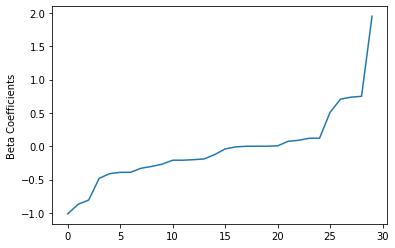

In [53]:
#参数
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

In [54]:
lrModel.coefficients

DenseVector([-0.2104, -0.3307, -0.191, 0.1191, -0.3034, 0.7497, -0.4829, 0.7075, 0.0891, -0.2699, -0.3923, -0.2021, -0.0413, -0.2099, 0.1209, -0.4121, -0.8719, 0.737, 0.5085, 0.0732, -1.0168, -0.8087, -0.3913, 1.9523, -0.0098, 0.0, 0.0051, -0.1269, -0.0001, -0.0008])

In [55]:
trainingSummary = lrModel.summary
#areaUnderROC 约接近1 越好
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

Training set areaUnderROC: 0.8830810693134605


In [56]:
predictions = lrModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 37|management|  0.0|[1.11932069377777...|       0.0|[0.75386269038069...|
| 52|management|  0.0|[-0.7313547916937...|       1.0|[0.32489749814267...|
| 53|management|  0.0|[0.97903579869178...|       0.0|[0.72691685583707...|
| 57|management|  0.0|[1.19186117528286...|       0.0|[0.76707376867981...|
| 46|management|  0.0|[2.18654571344802...|       0.0|[0.89903478847763...|
| 36|management|  0.0|[1.02450571746264...|       0.0|[0.73584932891331...|
| 40|management|  0.0|[1.31959252844883...|       0.0|[0.78911390588636...|
| 46|management|  0.0|[0.12560836267206...|       0.0|[0.53136086860027...|
| 58|management|  0.0|[-2.4194555976955...|       1.0|[0.08170109050095...|
| 47|management|  0.0|[0.56449503800979...|       0.0|[0.63749196605022...|
+---+-------

In [58]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8961900242154376
